In [1]:
%load_ext autoreload
%autoreload 2

import os
import h5py
import seaborn as sns
import numpy as np
import pandas as pd
import scanpy as sc
import anndata
import csv
import gzip
import scipy.io

import scipy.sparse as sps
import matplotlib.pyplot as plt

from os.path import join
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.preprocessing import normalize

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

np.random.seed(1234)

sc.settings.verbosity = 3
sc.logging.print_header()

scanpy==1.7.2 anndata==0.7.8 umap==0.5.1 numpy==1.18.2 scipy==1.4.1 pandas==1.1.5 scikit-learn==0.24.2 statsmodels==0.11.1 python-igraph==0.9.4 louvain==0.7.0


## experiment id

In [2]:
exp_id = 'MCA' + '-1701'  # dataset_name + timestamp

## loading data

In [3]:
data_root = '../data/MCA/scjoint/data_atlas'

adata_rna = sc.read_h5ad(join(data_root, 'adata_rna_cache.h5ad'))
adata_atac = sc.read_h5ad(join(data_root, 'adata_atac_cache.h5ad'))
adata_rna.obs['domain'] = 'rna'
adata_atac.obs['domain'] = 'atac'

# these RNA types resemble a lot of ATAC types, remove them from the reference dataset
hole_type = ['Epicardial adipocyte', 'Erythroblasts', 'Kidney collecting duct cell', 'Kidney tubule cell', 'Pancreatic acinar cell'] #, 'Kupffer cell']
adata_rna = adata_rna[~adata_rna.obs.cell_type.isin(hole_type)].copy()

meta_rna = adata_rna.obs.copy()
meta_atac = adata_atac.obs.copy()

meta = pd.concat([meta_rna, meta_atac], axis=0)

In [4]:
adata_rna, adata_atac

(AnnData object with n_obs × n_vars = 41379 × 15519
     obs: 'Unnamed: 0', 'cell_ontology_class', 'domain', 'cell_type',
 AnnData object with n_obs × n_vars = 81173 × 15519
     obs: 'Unnamed: 0', 'cell_label', 'domain', 'cell_type')

In [5]:
# low-dimension representations of raw scATAC-seq data
atac_raw_emb = np.load('../cache/MCAOS_atac_tsne.npy')  # the same as MCAOS
atac_raw_emb.shape

(81173, 2)

In [6]:
# params dict of preprocessing 
ppd = {'binz': True, 
       'hvg_num':adata_atac.shape[1], 
       'lognorm':False, 
       'scale_per_batch':False,  
       'batch_label': 'domain',
       'type_label':  'cell_type',
       'knn': 10,
       'knn_by_tissue':False
       }  # default settings

#  outputs folder
output_dir = join(f'../outputs/{exp_id}')
os.makedirs(output_dir, exist_ok=True)

## model 

In [7]:
import sys
sys.path = ["../"] + sys.path

import src.scNCL as scNCL

In [8]:
model = scNCL.scNCL(
                n_latent=128, bn=False, dr=0.2, 
                cont_w=0.1, cont_tau=0.4,
        )
    
model.preprocess(
                [adata_rna, adata_atac],   # list of 'anndata' object
                atac_raw_emb,   
                adata_adt_inputs=None, 
                pp_dict = ppd
        )
    
if 1:
    model.train(
        batch_size=500, training_steps=800, 
        lr=0.01, weight_decay=5e-4,
        log_step=100, eval_atac=False, #eval_top_k=1, eval_open=True,  
    )
else:
    # loading checkpoints
    ckpt_path = join(output_dir, 'ckpt_800.pth')
    model.load_ckpt(ckpt_path)

If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes


Finding highly variable genes...


/home/yxh/anaconda3/envs/torch171/lib/python3.6/site-packages/scanpy/preprocessing/_highly_variable_genes.py:64: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  UserWarning,
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)
If you pass `n_top_genes`, all cutoffs are ignored.
extracting highly variable genes
--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


knn correct ratio = 0.9704
step 0, loss_cls=4.148, loss_l1_reg=0.010, center=(0.019, 0.015), corr=(0.000, 0.000), var=(0.656, 0.712), loss_cont=0.673, loss_align=0.000
step 100, loss_cls=0.425, loss_l1_reg=0.010, center=(0.102, 0.052), corr=(0.023, 0.011), var=(0.101, 0.189), loss_cont=0.562, loss_align=0.000
step 200, loss_cls=0.270, loss_l1_reg=0.010, center=(0.098, 0.058), corr=(0.019, 0.016), var=(0.104, 0.165), loss_cont=0.546, loss_align=0.000
step 300, loss_cls=0.230, loss_l1_reg=0.009, center=(0.090, 0.066), corr=(0.014, 0.019), var=(0.112, 0.146), loss_cont=0.537, loss_align=0.000
step 400, loss_cls=0.201, loss_l1_reg=0.008, center=(0.085, 0.067), corr=(0.012, 0.017), var=(0.119, 0.144), loss_cont=0.532, loss_align=0.000
step 500, loss_cls=0.186, loss_l1_reg=0.008, center=(0.083, 0.072), corr=(0.011, 0.018), var=(0.122, 0.134), loss_cont=0.527, loss_align=0.000
step 600, loss_cls=0.157, loss_l1_reg=0.008, center=(0.078, 0.068), corr=(0.009, 0.017), var=(0.131, 0.140), loss_con

In [10]:
model.eval(inplace=True)
atac_pred_type = model.annotate()

# saving model
scNCL.save_ckpts(output_dir, model, step=800)

In [12]:
adata_atac.obs['pred_type'] = atac_pred_type
adata_atac.obs['pred_conf'] = np.max(model.head_B, axis=1)
adata_atac.obsm['X_tsne'] = atac_raw_emb

... storing 'domain' as categorical
... storing 'pred_type' as categorical


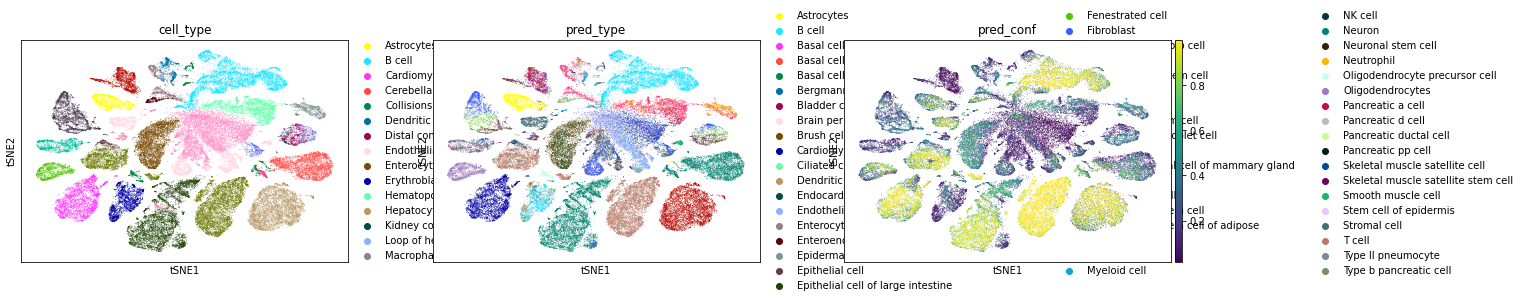

In [13]:
sc.pl.tsne(adata_atac, color=['cell_type', 'pred_type', 'pred_conf'])

## unify the cell-type colors

... storing 'union_type' as categorical


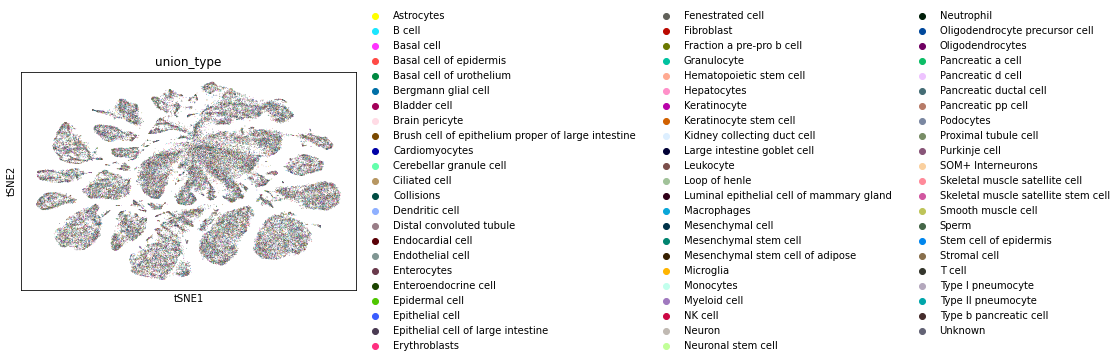

In [14]:
union_type = np.union1d(adata_atac.obs.cell_type.unique(), adata_atac.obs.pred_type.unique())

random_color = np.random.choice(union_type, size=adata_atac.shape[0], replace=True)
adata_atac.obs['union_type'] = random_color
sc.pl.tsne(adata_atac, color=['union_type'])

In [15]:
lab2color = dict(zip(adata_atac.obs.union_type.cat.categories, adata_atac.uns['union_type_colors']))

In [16]:
adata_atac.uns['cell_type_colors'] = [lab2color[_] for _ in adata_atac.obs.cell_type.cat.categories]
adata_atac.uns['pred_type_colors'] = [lab2color[_] for _ in adata_atac.obs.pred_type.cat.categories]

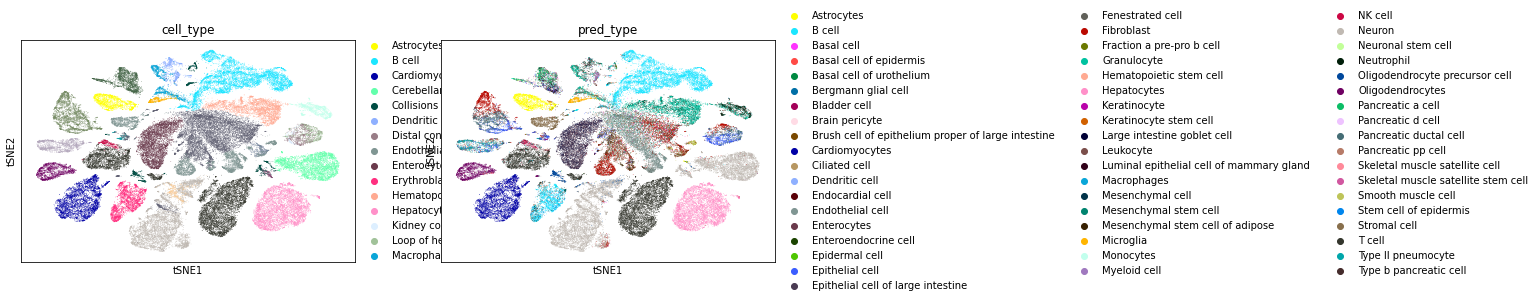

In [17]:
sc.pl.tsne(adata_atac, color=['cell_type', 'pred_type'])